# Abstract
Abstract (Work in progress):

Flight delays are a costly and frustrating inevitability for even the savviest of flyers. Itineraries that accurately account for delays stand to ease a major pain point for travelers on commercial airlines. Our project seeks to address this problem by predicting the length of flight delays using machine learning. To this end, we propose the use of a supervised Support Vector Regression model. Our proposed dataset contains flight data from 2009 to 2019, gathered from the US Department of Transportation's Bureau of Transportation Statistics. We plan to implement a machine learning pipeline for training and testing. The output of our final model will enable us to identify the variables associated with longer delays.

# Datasets

**Dataset #1**: Airline Delay Analysis - contains relevant information about most US flights for a period of ten years beginning in 2009 and ending in 2019.

Link: https://www.kaggle.com/datasets/sherrytp/airline-delay-analysis

Location: /content/airline_delay_analysis


# Team

Jason Bulux
jbulux@ucsd.edu

Rosario Ortiz
mdortiz@ucsd.edu

Kwadwo Danquah
kdanquah@ucsd.edu

Sam Kogan
skogan@ucsd.edu

# Setup

[README](https://github.com/litAardvark/CSE151A_Group_Project_SII25/blob/main/README.md)

Mounted G drive to be able to use kaggle API key to download and unzip the dataset into the session.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

kaggle API key saved on Google Drive at the path:
MyDrive/Colab Notebooks

In [ ]:
!mkdir ~/.kaggle
!cp '/content/drive/MyDrive/Colab Notebooks/kaggle.json' ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

Download dataset from kaggle.

In [ ]:
!kaggle datasets download -d sherrytp/airline-delay-analysis

Unzip it into the session.

In [ ]:
!unzip airline-delay-analysis.zip

**DATA EXPLORATION**

Check for empty cells and duplicated rows in the dataset.

In [ ]:
import pandas as pd

total_empty_cells = 0
duplicates = 0

print("checking dataset for missing and duplicated data")
filepath = '/content/airline delay analysis'

# The chosen csv files will be combined into one df
concatenated_df = pd.DataFrame()

for d in range(2018, 2019): #The loop excludes the endpoint
  print("checking ", d)
  df = pd.read_csv(f'{filepath}/{d}.csv')

# Drop empty columns and rows
df = df.dropna(axis=1, how='all')
df = df.dropna(axis=0, how='all')

# Check remaining columns for empty cells
empty_cells = df.isnull().sum()

#print(empty_cells)
total_empty_cells += empty_cells.sum()
duplicates += df.duplicated().sum()

print("total empty cells:", total_empty_cells)
print("duplicates:", duplicates)
print("total rows:", len(df))
print("total columns:", len(df.columns))
print("columns:", df.columns.to_list())

total empty cells: 37625423
duplicates: 0
total rows: 7213446
total columns: 27
columns: ['FL_DATE', 'OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']


**ALWAYS RUN 5TH CELL AGAIN BEFORE RUNNING EITHER OF THE CELLS BELOW**

Re-run 5th cell before running the cell below.

In [ ]:
#Checking dataset info if target = ARR_DELAY

# Define the columns to scan
selected_columns = ['FL_DATE', 'OP_CARRIER', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'DEP_DELAY', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY']
# Filter out rows where 'CANCELLED' is 0
df = df[df['CANCELLED'] != 1]
df = df[df['DIVERTED'] != 1]
df.drop(columns=['CANCELLED'], inplace=True)
df.drop(columns=['DIVERTED'], inplace=True)
# Select only the specified columns
feature_df = df[selected_columns]
#target_df = df['ARR_DELAY']

print("features:", feature_df.columns.to_list())
print("feature shape:", feature_df.shape)
#print("target shape:", target_df.shape)

features: ['FL_DATE', 'OP_CARRIER', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'DEP_DELAY', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY']
feature shape: (7079005, 9)


##Exploratory Data Analysis

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

numerical_cols = feature_df.select_dtypes(include=["number"]).columns
sns.heatmap(feature_df[numerical_cols],
            annot=True,
            linewidth=.5,
            cmap = sns.color_palette("magma", as_cmap=True))

In [ ]:
sns.barplot(feature_df, x="OP_CARRIER", y="ARR_DELAY")
sns.barplot(feature_df, x="DEST", y="ARR_DELAY")
sns.barplot(feature_df, x="ORIGIN", Y="ARR_DELAY")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# select features
features = ['CRS_DEP_TIME', 'DEP_DELAY', 'DISTANCE', 'CRS_ELAPSED_TIME']
df_corr = pd.concat([concatenated_df[features].copy(), target_df], axis = 1)


# compute corr matrix
corr = df_corr.corr()

# plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, vmin = -1, vmax = 1, cmap="coolwarm", fmt=".2f")
plt.show()

In [ ]:
sns.pairplot(pd.concat(concatenated_df[features], target_df))

The pairplot below was generated locally from the 2018 dataset using the code

```
df_2018 = pd.read_csv(f'{filepath}/2018.csv')
selected_columns = ['FL_DATE', 'OP_CARRIER', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'DEP_DELAY', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY']
df_2018_select = df_2018[[selected_columns]]
sns.pairplot(df_2018_select)
```



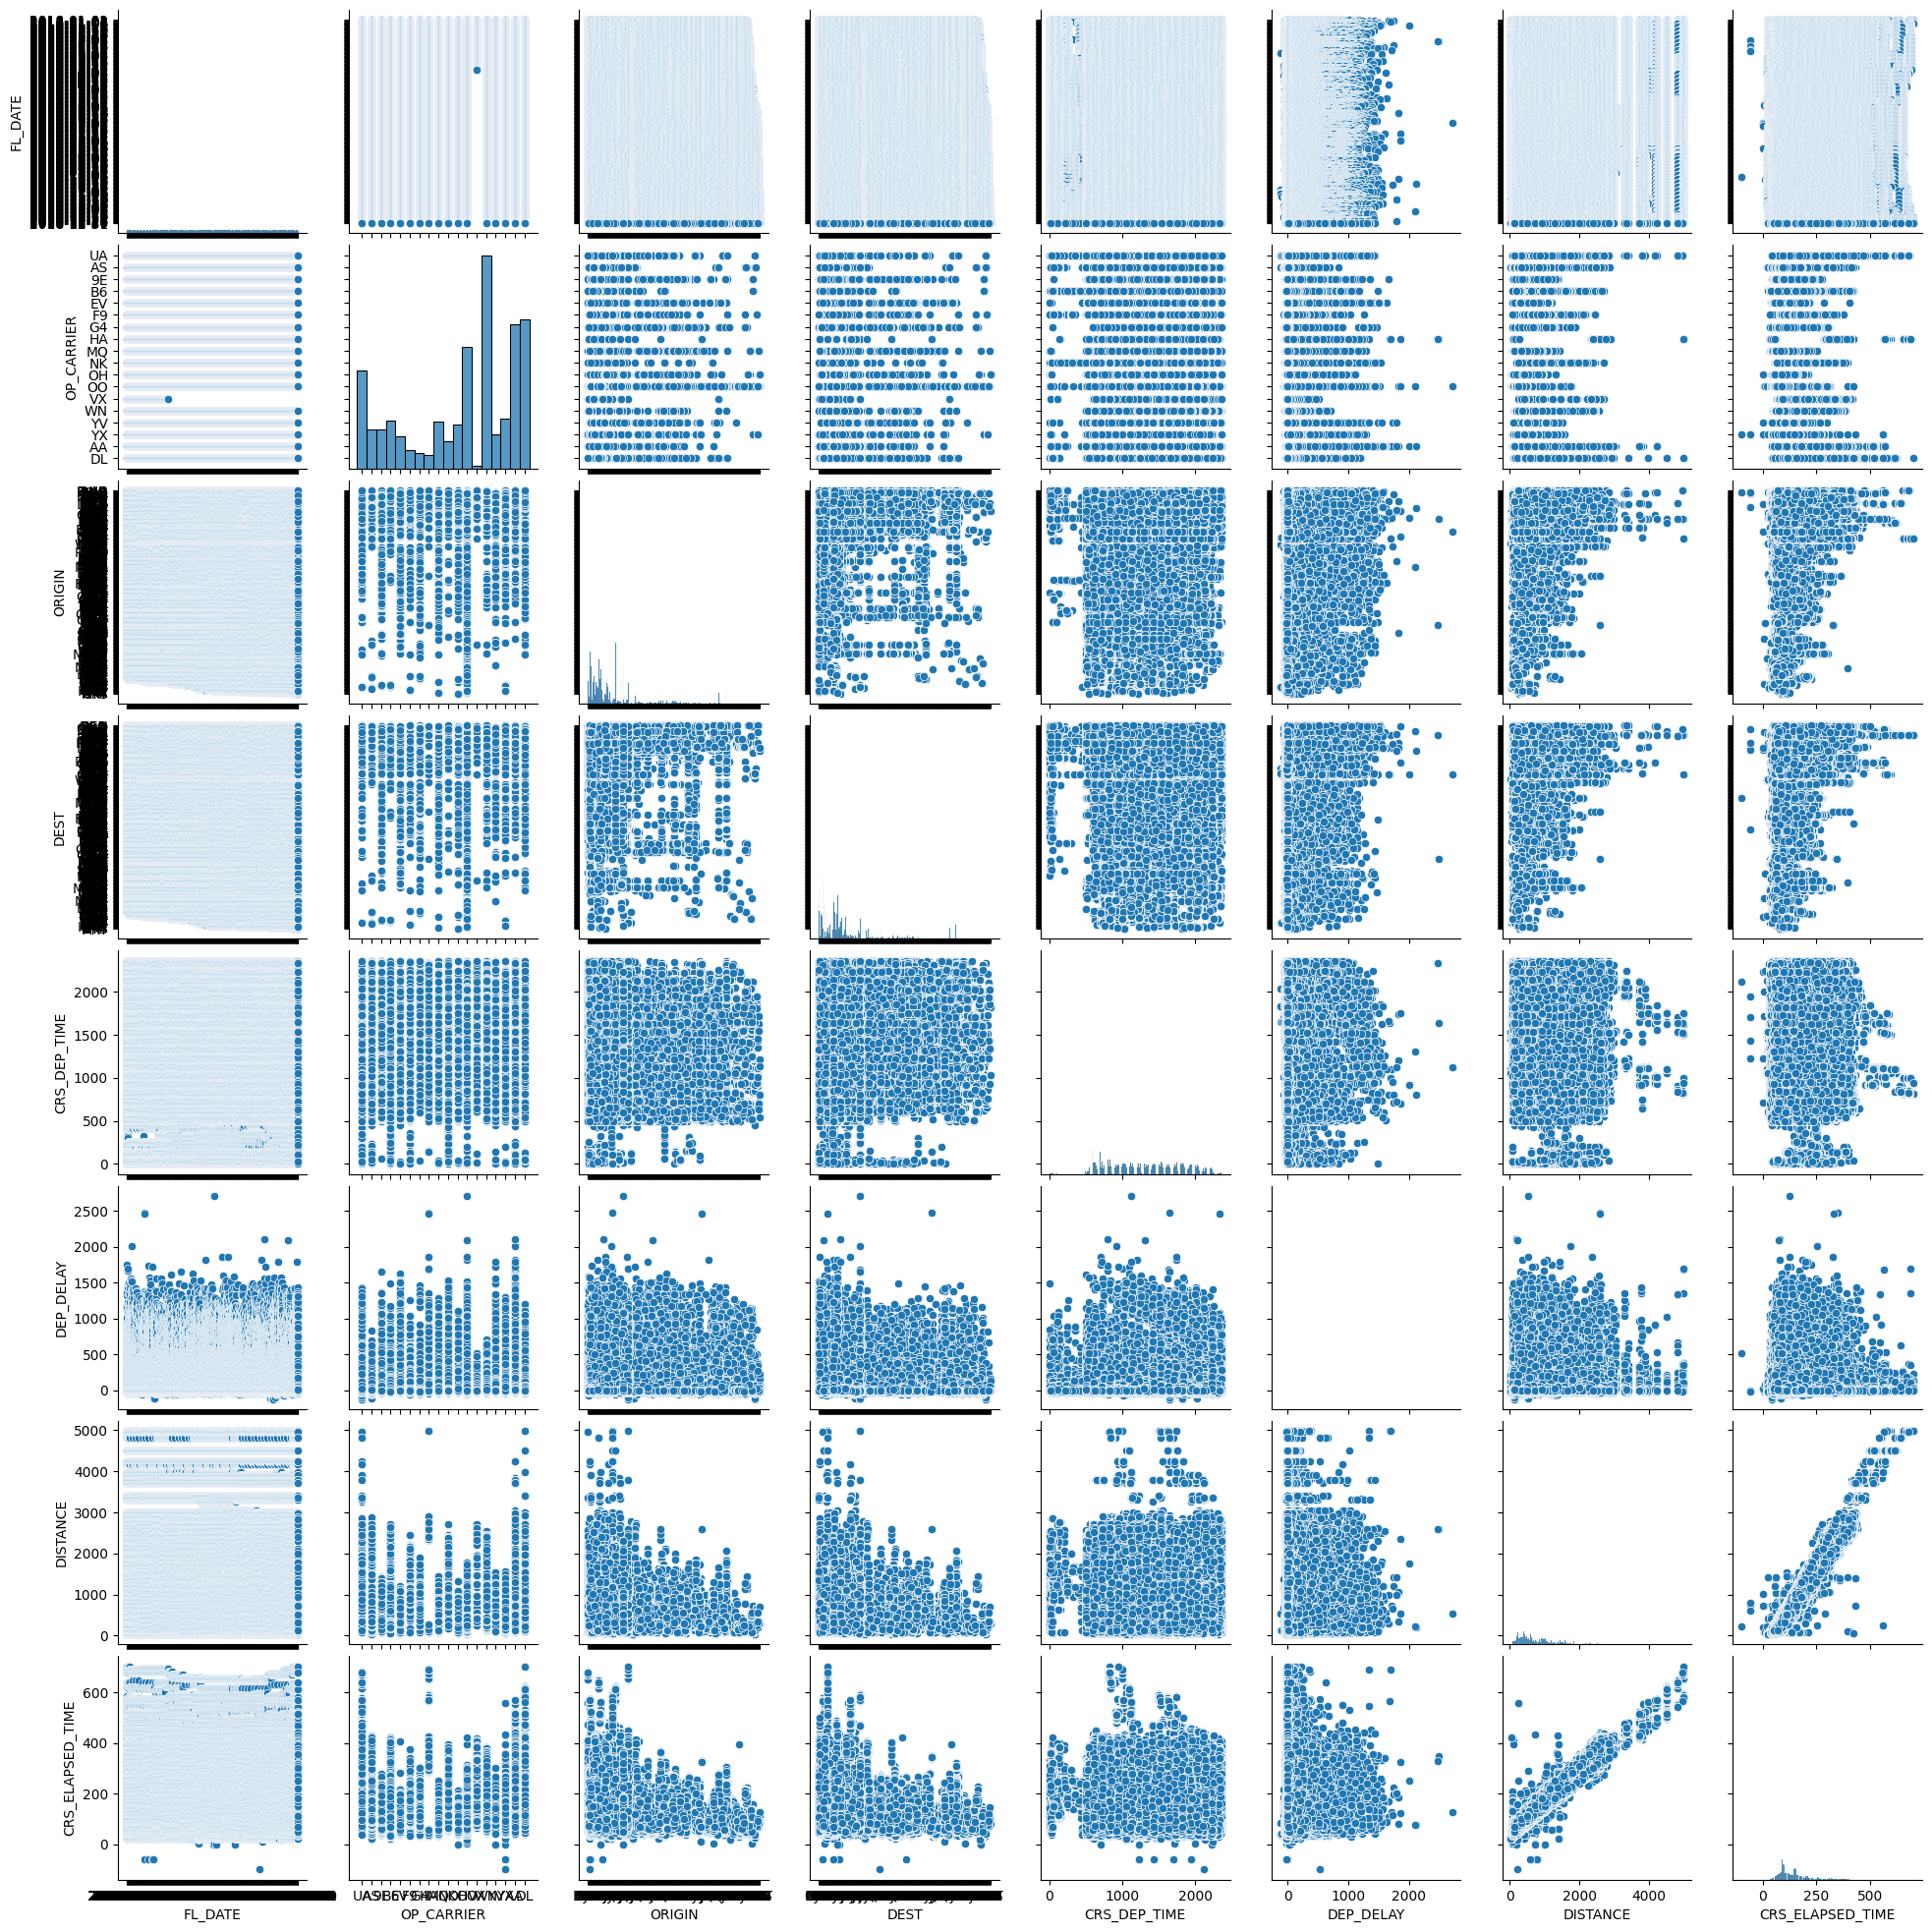

**Data Reduction**

In [ ]:
reduced_feature_df = feature_df.sample(frac=0.07, random_state=42).reset_index(drop=True)
# print(reduced_feature_df.shape)

**Categorical Data**

In [ ]:

categorical_feats = ["OP_CARRIER", "ORIGIN", "DEST"]
def replace_missing_mode(df, cats):
  modes = []
  #calculate mode of each categorical column
  for f in cats:
     mode = reduced_feature_df[f].mode()
     print (f"Mode of {f} is: {mode}")
     df[f].fillna(mode)



In [ ]:
def one_hot_encode (df, cats):
  for f in cats:
    enc = pd.get_dummies(df[f], dtype=int, prefix=str(f))
    df = df.drop(f, axis = 1)
    df = pd.concat([df, enc], axis=1)
  return df

reduced_feature_df = one_hot_encode(reduced_feature_df, categorical_feats)

**Numerical Encoding**

In [ ]:
import numpy as np
from datetime import datetime

display(reduced_feature_df.head())
cycled_feature_df = reduced_feature_df.copy()
missing = reduced_feature_df.isnull().sum()
print("empty cells: ",missing)


# Encode time as a cycle
def transform_time_cyclical(df, col, max):
    transformed = np.sin(2 * np.pi * df[col] / max)
    return transformed

print("Encoding raw time as a cycle...")
cycled_feature_df['CRS_DEP_TIME'] = transform_time_cyclical(reduced_feature_df, 'CRS_DEP_TIME', 2400)
display(cycled_feature_df.head())


# Replace missing value with the mean
print("Replacing missing numerical values...")
num_feats = ['CRS_DEP_TIME', 'DEP_DELAY', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY']
for col in num_feats:
  cycled_feature_df[col] = np.where(cycled_feature_df[col].isnull(), np.nanmean(cycled_feature_df[col]), cycled_feature_df[col])

missing = cycled_feature_df.isnull().sum()
print("empty cells after: ", missing)

# Encode the dates as numerical values on a 365 cycle
print("Encoding date as a cycle...")
cycled_feature_df['FL_DATE'] = pd.to_datetime(cycled_feature_df['FL_DATE'])
cycled_feature_df['FL_DATE'] = cycled_feature_df['FL_DATE'].map(lambda x: x.timetuple().tm_yday)
cycled_feature_df['FL_DATE'] = transform_time_cyclical(cycled_feature_df,'FL_DATE', 365)
display(cycled_feature_df.head())



FL_DATE  CRS_DEP_TIME  DEP_DELAY  DISTANCE  CRS_ELAPSED_TIME  ARR_DELAY  \
0  2018-03-22          1905       -6.0     933.0             148.0      -16.0   
1  2018-12-27          1140       28.0     307.0              75.0       48.0   
2  2018-06-05          1842       -9.0     602.0             103.0      -13.0   
3  2018-05-17          1220       57.0     393.0             120.0       47.0   
4  2018-09-11          1714       -8.0    1144.0             201.0      -18.0   

   OP_CARRIER_9E  OP_CARRIER_AA  OP_CARRIER_AS  OP_CARRIER_B6  ...  DEST_UIN  \
0              0              0              1              0  ...         0   
1              0              0              0              0  ...         0   
2              0              0              0              0  ...         0   
3              0              0              0              0  ...         0   
4              0              1              0              0  ...         0   

   DEST_USA  DEST_VEL  DEST_VLD  DEST_VPS  DEST_WRG  DEST_WYS  DEST_XNA  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0         0         0   
2         0         0         0         0         0         0         0   
3         0         0         0         0         0         0         0   
4         0         0         0         0         0         0         0   

   DEST_YAK  DEST_YUM  
0         0         0  
1         0         0  
2         0         0  
3         0         0  
4         0         0  

[5 rows x 738 columns]

empty cells:  FL_DATE               0
CRS_DEP_TIME          0
DEP_DELAY           316
DISTANCE              0
CRS_ELAPSED_TIME      0
                   ... 
DEST_WRG              0
DEST_WYS              0
DEST_XNA              0
DEST_YAK              0
DEST_YUM              0
Length: 738, dtype: int64
Encoding raw time as a cycle...


FL_DATE  CRS_DEP_TIME  DEP_DELAY  DISTANCE  CRS_ELAPSED_TIME  ARR_DELAY  \
0  2018-03-22     -0.962455       -6.0     933.0             148.0      -16.0   
1  2018-12-27      0.156434       28.0     307.0              75.0       48.0   
2  2018-06-05     -0.993961       -9.0     602.0             103.0      -13.0   
3  2018-05-17     -0.052336       57.0     393.0             120.0       47.0   
4  2018-09-11     -0.974761       -8.0    1144.0             201.0      -18.0   

   OP_CARRIER_9E  OP_CARRIER_AA  OP_CARRIER_AS  OP_CARRIER_B6  ...  DEST_UIN  \
0              0              0              1              0  ...         0   
1              0              0              0              0  ...         0   
2              0              0              0              0  ...         0   
3              0              0              0              0  ...         0   
4              0              1              0              0  ...         0   

   DEST_USA  DEST_VEL  DEST_VLD  DEST_VPS  DEST_WRG  DEST_WYS  DEST_XNA  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0         0         0   
2         0         0         0         0         0         0         0   
3         0         0         0         0         0         0         0   
4         0         0         0         0         0         0         0   

   DEST_YAK  DEST_YUM  
0         0         0  
1         0         0  
2         0         0  
3         0         0  
4         0         0  

[5 rows x 738 columns]

Replacing missing numerical values...
empty cells after:  FL_DATE             0
CRS_DEP_TIME        0
DEP_DELAY           0
DISTANCE            0
CRS_ELAPSED_TIME    0
                   ..
DEST_WRG            0
DEST_WYS            0
DEST_XNA            0
DEST_YAK            0
DEST_YUM            0
Length: 738, dtype: int64
Encoding date as a cycle...


FL_DATE  CRS_DEP_TIME  DEP_DELAY  DISTANCE  CRS_ELAPSED_TIME  ARR_DELAY  \
0  0.984474     -0.962455       -6.0     933.0             148.0      -16.0   
1 -0.068802      0.156434       28.0     307.0              75.0       48.0   
2  0.440519     -0.993961       -9.0     602.0             103.0      -13.0   
3  0.705584     -0.052336       57.0     393.0             120.0       47.0   
4 -0.942761     -0.974761       -8.0    1144.0             201.0      -18.0   

   OP_CARRIER_9E  OP_CARRIER_AA  OP_CARRIER_AS  OP_CARRIER_B6  ...  DEST_UIN  \
0              0              0              1              0  ...         0   
1              0              0              0              0  ...         0   
2              0              0              0              0  ...         0   
3              0              0              0              0  ...         0   
4              0              1              0              0  ...         0   

   DEST_USA  DEST_VEL  DEST_VLD  DEST_VPS  DEST_WRG  DEST_WYS  DEST_XNA  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0         0         0   
2         0         0         0         0         0         0         0   
3         0         0         0         0         0         0         0   
4         0         0         0         0         0         0         0   

   DEST_YAK  DEST_YUM  
0         0         0  
1         0         0  
2         0         0  
3         0         0  
4         0         0  

[5 rows x 738 columns]

**First Model**

**Scale Data**

In [ ]:
# Split data
from sklearn.model_selection import train_test_split
print("Splitting data...")
x_train, x_test, y_train, y_test = train_test_split(cycled_feature_df.drop('ARR_DELAY', axis=1), cycled_feature_df['ARR_DELAY'], test_size=0.2, random_state=42)

def z_score_scale(df):
    mean = df.mean()
    std = df.std()
    df = (df - mean) / std
    return df

# Scale numerical data
print("Scaling numerical data...")
scale_feats = ['DEP_DELAY', 'DISTANCE', 'CRS_ELAPSED_TIME']
x_train[scale_feats] = z_score_scale(x_train[scale_feats])
x_test[scale_feats] = z_score_scale(x_test[scale_feats])
y_train = z_score_scale(y_train)
y_test = z_score_scale(y_test)

print("Train")
display(x_train.head())
display(y_train.head())

print("Test")
display(x_test.head())
display(y_test.head())

Splitting data...


Scaling numerical data...
Train


FL_DATE  CRS_DEP_TIME  DEP_DELAY  DISTANCE  CRS_ELAPSED_TIME  \
148851 -0.999991     -0.793353  -0.376553  0.096991          0.090001   
41217  -0.263665      0.182236  -0.398826  0.368975          0.335077   
358674  0.493776      0.442289  -0.332006 -0.872474         -0.863071   
323034 -0.230306     -0.793353   4.590401  2.838525          2.336529   
291360  0.888057     -0.991445   1.561227 -0.033161         -0.209536   

        OP_CARRIER_9E  OP_CARRIER_AA  OP_CARRIER_AS  OP_CARRIER_B6  \
148851              0              0              0              0   
41217               0              0              0              0   
358674              0              0              0              0   
323034              0              0              0              0   
291360              0              1              0              0   

        OP_CARRIER_DL  ...  DEST_UIN  DEST_USA  DEST_VEL  DEST_VLD  DEST_VPS  \
148851              0  ...         0         0         0         0         0   
41217               1  ...         0         0         0         0         0   
358674              0  ...         0         0         0         0         0   
323034              0  ...         0         0         0         0         0   
291360              0  ...         0         0         0         0         0   

        DEST_WRG  DEST_WYS  DEST_XNA  DEST_YAK  DEST_YUM  
148851         0         0         0         0         0  
41217          0         0         0         0         0  
358674         0         0         0         0         0  
323034         0         0         0         0         0  
291360         0         0         0         0         0  

[5 rows x 737 columns]

148851   -0.213537
41217    -0.552579
358674   -0.383058
323034    4.978050
291360    1.714767
Name: ARR_DELAY, dtype: float64

Test


FL_DATE  CRS_DEP_TIME  DEP_DELAY  DISTANCE  CRS_ELAPSED_TIME  \
352455  0.880012     -0.117537  -0.048248  1.540879          1.188847   
485907 -0.972118     -0.039260   0.176851 -0.644318         -0.766563   
285266  0.615285     -0.965926  -0.340877 -1.038315         -1.144159   
17066   0.674444     -0.988094  -0.250837  0.009586          0.271827   
146799 -0.017213     -0.992439  -0.340877 -1.084668         -1.076731   

        OP_CARRIER_9E  OP_CARRIER_AA  OP_CARRIER_AS  OP_CARRIER_B6  \
352455              0              0              0              0   
485907              0              0              0              0   
285266              0              0              0              0   
17066               0              1              0              0   
146799              1              0              0              0   

        OP_CARRIER_DL  ...  DEST_UIN  DEST_USA  DEST_VEL  DEST_VLD  DEST_VPS  \
352455              0  ...         0         0         0         0         0   
485907              0  ...         0         0         0         0         0   
285266              0  ...         0         0         0         0         0   
17066               0  ...         0         0         0         0         0   
146799              0  ...         0         0         0         0         0   

        DEST_WRG  DEST_WYS  DEST_XNA  DEST_YAK  DEST_YUM  
352455         0         0         0         0         0  
485907         0         0         0         0         0  
285266         0         0         0         0         0  
17066          0         0         0         0         0  
146799         0         0         0         0         0  

[5 rows x 737 columns]

352455   -0.199065
485907    0.078933
285266   -0.006605
17066    -0.605369
146799   -0.348756
Name: ARR_DELAY, dtype: float64

**Train And Evaluate First Model**

In [ ]:
# SVR model
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

num_feats = ['FL_DATE','CRS_DEP_TIME', 'DEP_DELAY', 'DISTANCE', 'CRS_ELAPSED_TIME']


# Fraction of data to train on
fraction = 1.0


x_train = x_train.sample(frac=fraction, random_state=42)
y_train = y_train.sample(frac=fraction, random_state=42)
x_test = x_test.sample(frac=fraction, random_state=42)
y_test = y_test.sample(frac=fraction, random_state=42)

model = SVR(kernel='linear', C=5, epsilon=.001)
model.fit(x_train[num_feats], y_train)


train_mse = mean_squared_error(y_train, model.predict(x_train[num_feats]))
train_r2 = r2_score(y_train, model.predict(x_train[num_feats]))

y_pred = model.predict(x_test[num_feats])
test_mse = mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)


print("\nRegression Report For Model 1")
print("Model 1 TRAIN MSE: ", train_mse)
print("Model 1 TRAIN R2: ", train_r2)

print("Model 1 TEST MSE: ", test_mse)
print("Model 1 TEST R2: ", test_r2)

# Model 2
model = SVR(kernel='linear', C=50, epsilon=.1)
model.fit(x_train[num_feats], y_train)


train_mse = mean_squared_error(y_train, model.predict(x_train[num_feats]))
train_r2 = r2_score(y_train, model.predict(x_train[num_feats]))

y_pred = model.predict(x_test[num_feats])
test_mse = mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)


print("\nRegression Report For Model 2")
print("Model 2 TRAIN MSE: ", train_mse)
print("Model 2 TRAIN R2: ", train_r2)

print("Model 2 TEST MSE: ", test_mse)
print("Model 2 TEST R2: ", test_r2)


Regression Report For Model 1

Model 1 TRAIN MSE:  0.08043516947472854

Model 1 TRAIN R2:  0.919562772043647

Model 1 TEST MSE:  0.0708806408796149

Model 1 TEST R2:  0.9291121027075187


Regression Report For Model 2

Model 2 TRAIN MSE:  0.07989354879871627

Model 2 TRAIN R2:  0.920104406580713

Model 2 TEST MSE:  0.07033603081722742

Model 2 TEST R2:  0.929656768524417

**SECOND MODEL**

Using Unsupervised Learning to understand our data



In [ ]:
unsupervised_df = cycled_feature_df.copy()
#unsupervised_df = unsupervised_df.drop(['FL_DATE', 'DEP_DELAY', 'ARR_DELAY'], axis=1) # We don't know what the unsupervised model will learn so we give it more information

Explained variance ratio: [0.00400165 0.0033222  0.00298031 0.00288288 0.00284288 0.00273687]
Principal components:
 [[ 0.00504474  0.02746925 -0.0176068  ... -0.02209778  0.00269071
  -0.00894966]
 [-0.00375199  0.00372994 -0.08101275 ...  0.00485389  0.00579758
   0.00298344]
 [-0.00165177  0.01131055 -0.1160684  ... -0.02612084  0.02426002
   0.01169448]
 [-0.00768775  0.04719361 -0.22164413 ...  0.00956564  0.06616057
   0.00639073]
 [ 0.01031114 -0.03446476  0.16224772 ... -0.00704257 -0.03173278
  -0.00111845]
 [-0.01547086 -0.07082413  0.33463585 ...  0.0119102  -0.02266467
   0.01490291]]


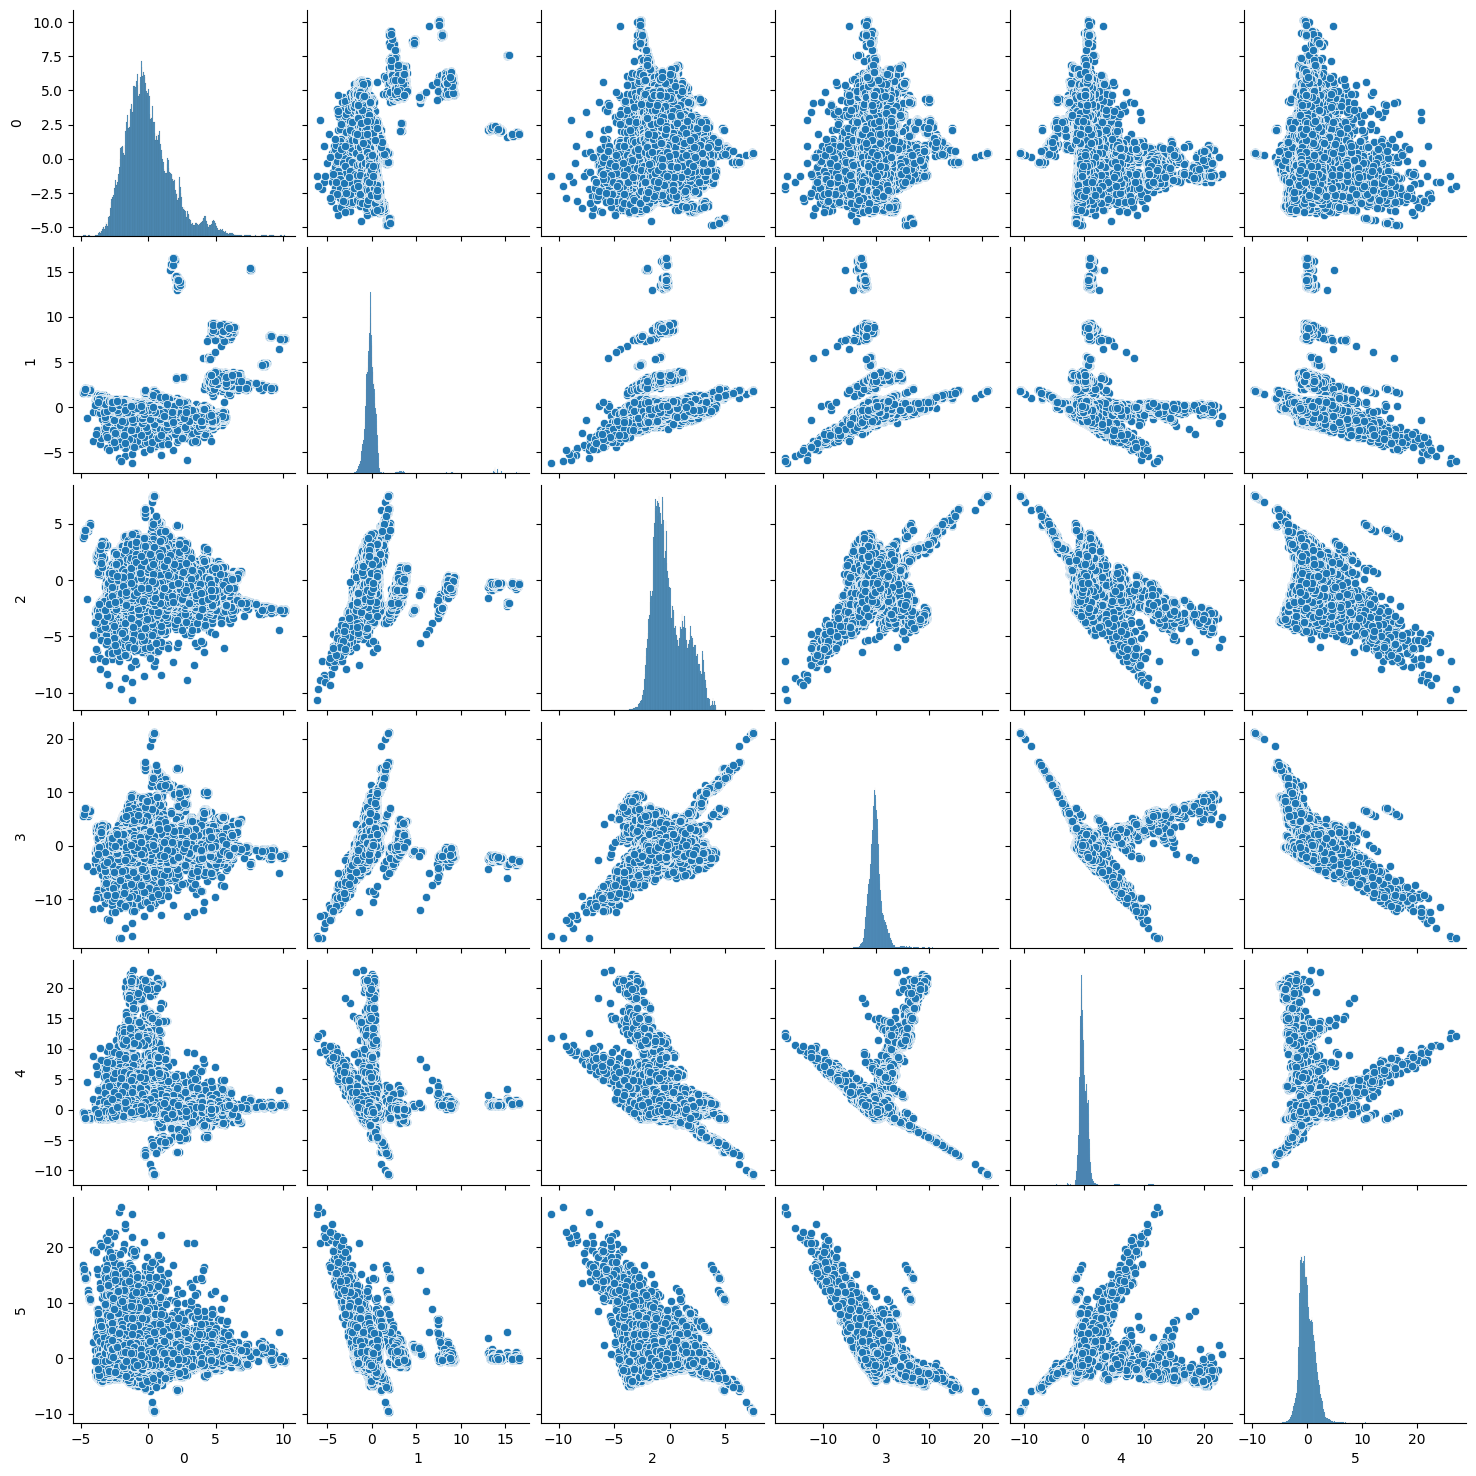

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X_scaled = scaler.fit_transform(unsupervised_df)


pca = PCA(n_components=6) # Vary this for better clustering?
X_pca = pca.fit_transform(X_scaled)

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Principal components:\n", pca.components_)

sns.pairplot(pd.DataFrame(X_pca))
plt.show()

**Cluster**

Perform K-Means Clustering on the PCA reduced data for labels.

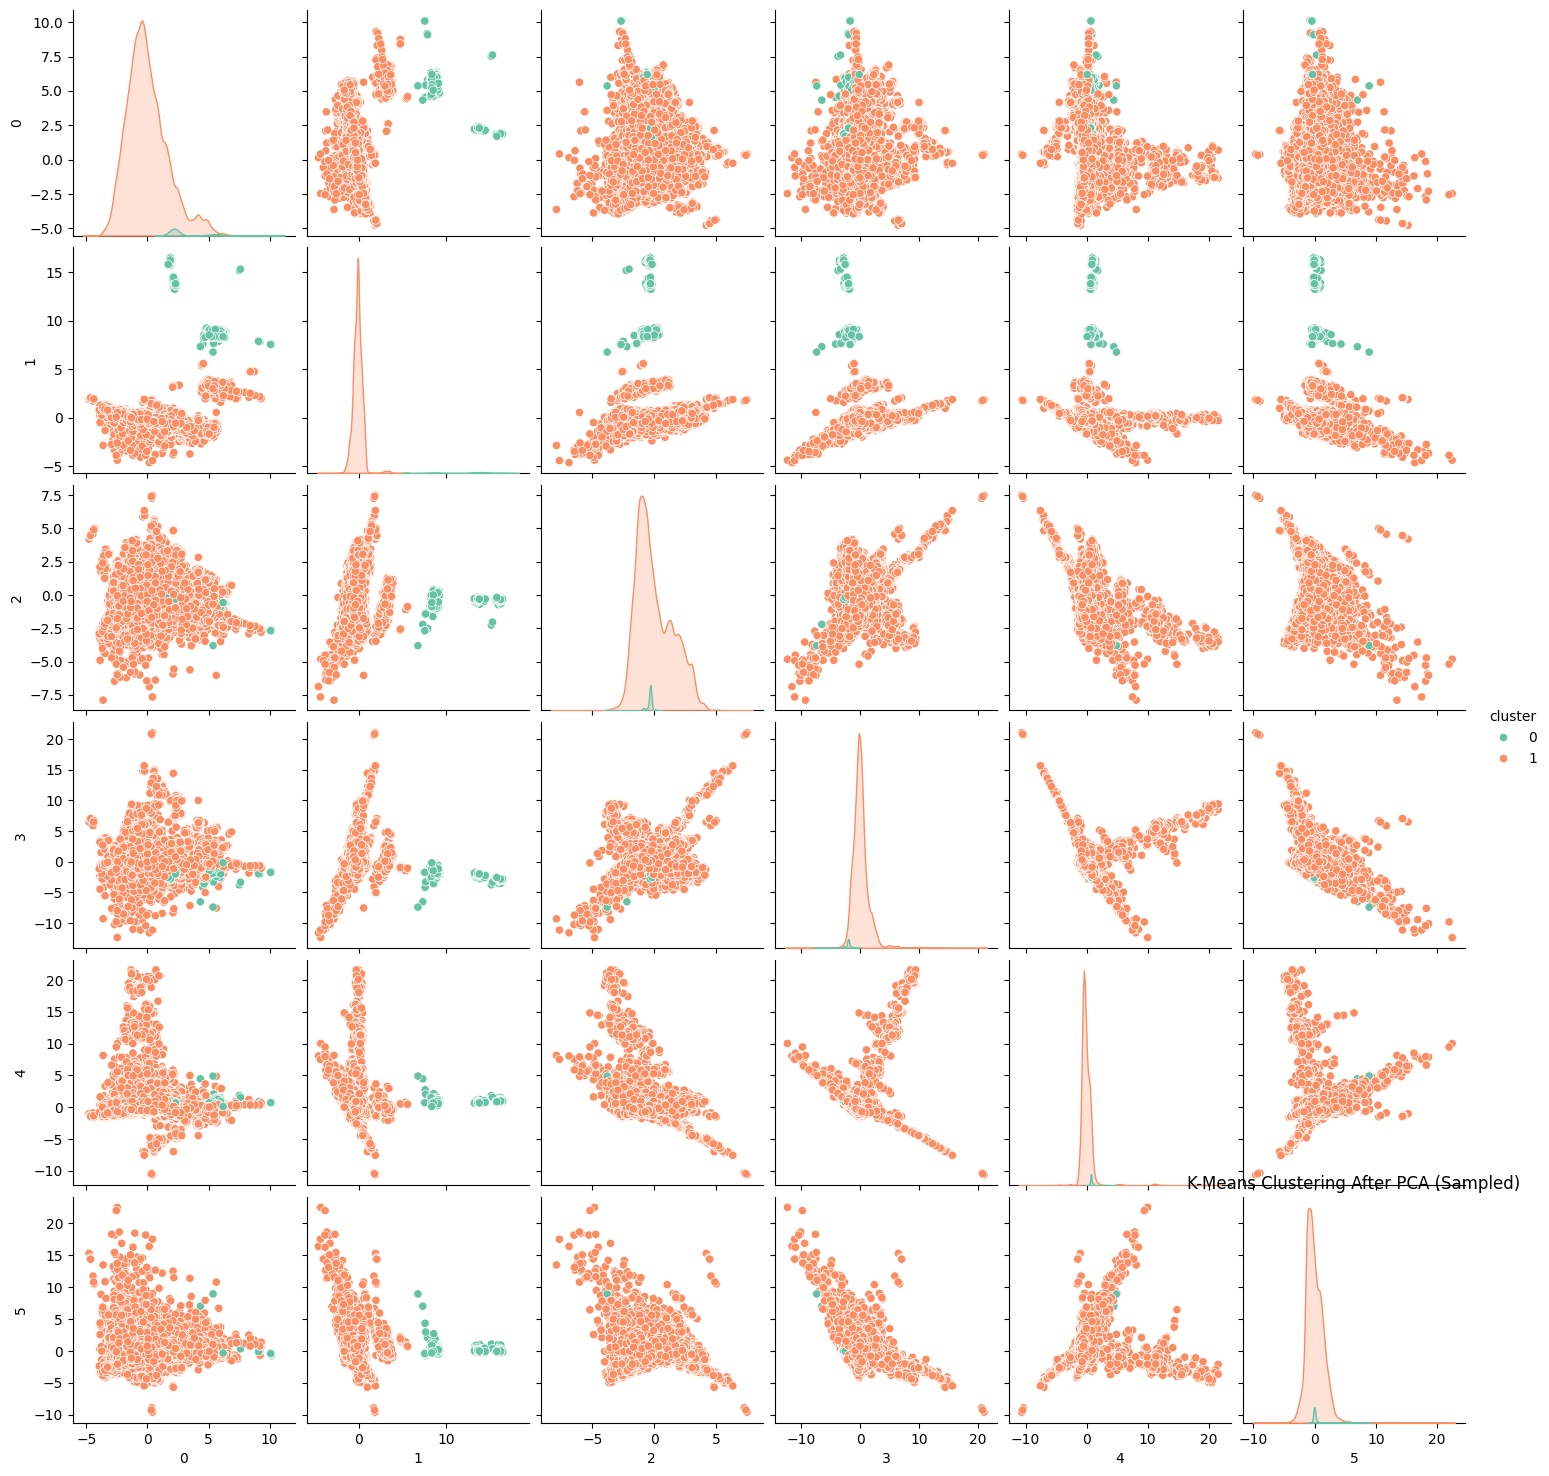

Silhouette Score (sampled): 0.7147110306556969


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10, algorithm='elkan') #UPDATED: added 2 more parameters to optimize threads when running the kernel
clusters = kmeans.fit_predict(X_pca)

clustered_df = pd.DataFrame(X_pca)
clustered_df['cluster'] = clusters

#UPDATED: Added one more line to subsample
plot_sample = clustered_df.sample(n=100000, random_state=42)
sns.pairplot(plot_sample, hue='cluster', palette='Set2')
plt.title("K-Means Clustering After PCA (Sampled)")
plt.show()


# UPDATED: Subsample for silhouette score using NumPy indices
indices = np.random.choice(X_pca.shape[0], size=100000, replace=False)
score = silhouette_score(X_pca[indices], clusters[indices]) #UPDATED: Modified parameters to keep consistent with NumPy-based sampling here and the next cell block.
print("Silhouette Score (sampled):", score)

**Split Data and Train an SVM model**

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix

print(X_pca.shape)
X_train, X_test, y_train, y_test = train_test_split(X_pca, clusters, test_size=0.2, random_state=42)

#UPDATED: Used LinearSVC for scalability
svm = LinearSVC(random_state=42, max_iter=5000)
svm.fit(X_train, y_train)

# Get accuracy
train_acc = svm.score(X_train, y_train)
test_acc = svm.score(X_test, y_test)

# Error rates (1 - accuracy)
train_error = 1 - train_acc
test_error = 1 - test_acc

print(f"TRAIN Accuracy: {train_acc:.4f}")
print(f"TEST Accuracy:  {test_acc:.4f}")
print(f"TRAIN Error:    {train_error:.4f}")
print(f"TEST Error:     {test_error:.4f}")

cm = confusion_matrix(y_test, svm.predict(X_test))
print('\nConfusion Matrix', cm)

FP = cm[0, 1]
FN = cm[1, 0]
TP = cm[1, 1]
TN = cm[0, 0]

print('False Positives:', FP)
print('False Negatives:', FN)
print('True Positives:', TP)
print('True Negatives:', TN)

(495530, 6)


TRAIN Accuracy: 1.0000
TEST Accuracy:  1.0000
TRAIN Error:    0.0000
TEST Error:     0.0000

Confusion Matrix [[ 1167     0]
 [    0 97939]]
False Positives: 0
False Negatives: 0
True Positives: 97939
True Negatives: 1167
